In [42]:
from typing import Callable
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score
from time import time_ns
import seaborn as sns
from sklearn.linear_model import LogisticRegression
plt.rcParams["figure.figsize"] = (20,10)

In [43]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [44]:
def mse_cost(predicted, actual):
    return np.mean((predicted - actual) ** 2)


def logistic_cost(predicted, actual):
    return -np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

In [45]:
class MyLogisticRegression:
    def __init__(self, learning_rate: float = 0.05, max_iterations: int = 100, min_cost_diff: float = 0.001,
                 cost_function: Callable = mse_cost):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.min_cost_diff = min_cost_diff
        self.coef_ = None
        self.intercept_ = None
        self.cost_function = cost_function
        self.costs = []

    def fit(self, X, Y):
        if self.coef_ is None:
            self.coef_ = np.random.normal(loc=1, scale=0.15, size=(1, X.shape[1]))
            self.intercept_ = np.random.normal(loc=1, scale=0.15, size=1)

        Y = Y.reshape(-1, 1)
        n = X.shape[0]
        for i in range(self.max_iterations):
            preds = sigmoid(X.dot(self.coef_.T) + self.intercept_)
            cost = self.cost_function(preds, Y)

            dW = 1/n * np.dot((preds - Y).T, X)
            dB = 1/n * np.sum(preds - Y)

            self.coef_ = self.coef_ - self.learning_rate * dW
            self.intercept_ = self.intercept_ - self.learning_rate * dB

            self.costs.append(cost)

            if len(self.costs) >= 2 and self.costs[-2] - self.costs[-1] < self.min_cost_diff:
                break

        return self

    def decision_function(self, X):
        return sigmoid(X.dot(self.coef_.T) + self.intercept_)

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)

In [46]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v

In [68]:
def compare_models(my_model, sk_model, data: PUMData):
    my_start = time_ns()
    my_model.fit(data.x_train, data.y_train)
    my_time = time_ns() - my_start

    sk_start = time_ns()
    sk_model.fit(data.x_train, data.y_train)
    sk_time = time_ns() - sk_start

    print(f'Implementacja wlasna uczyla sie przez \t{my_time} ns')
    print(f'Model sklearn uczyl sie przez \t\t\t{sk_time} ns')

    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z_an = my_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    Z_sk = sk_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model LogisticRegression']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted)
    cm_an = confusion_matrix(data.y_test, y_an_predicted)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model LogisticRegression']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

    my_function = my_model.decision_function(data.x_test)
    sk_function = sk_model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
    fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
    plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
    plt.legend()
    plt.show()

In [63]:
random_state = 244827
n_samples = 2427

Implementacja wlasna uczyla sie przez 	2976200 ns
Model sklearn uczyl sie przez 			2975600 ns


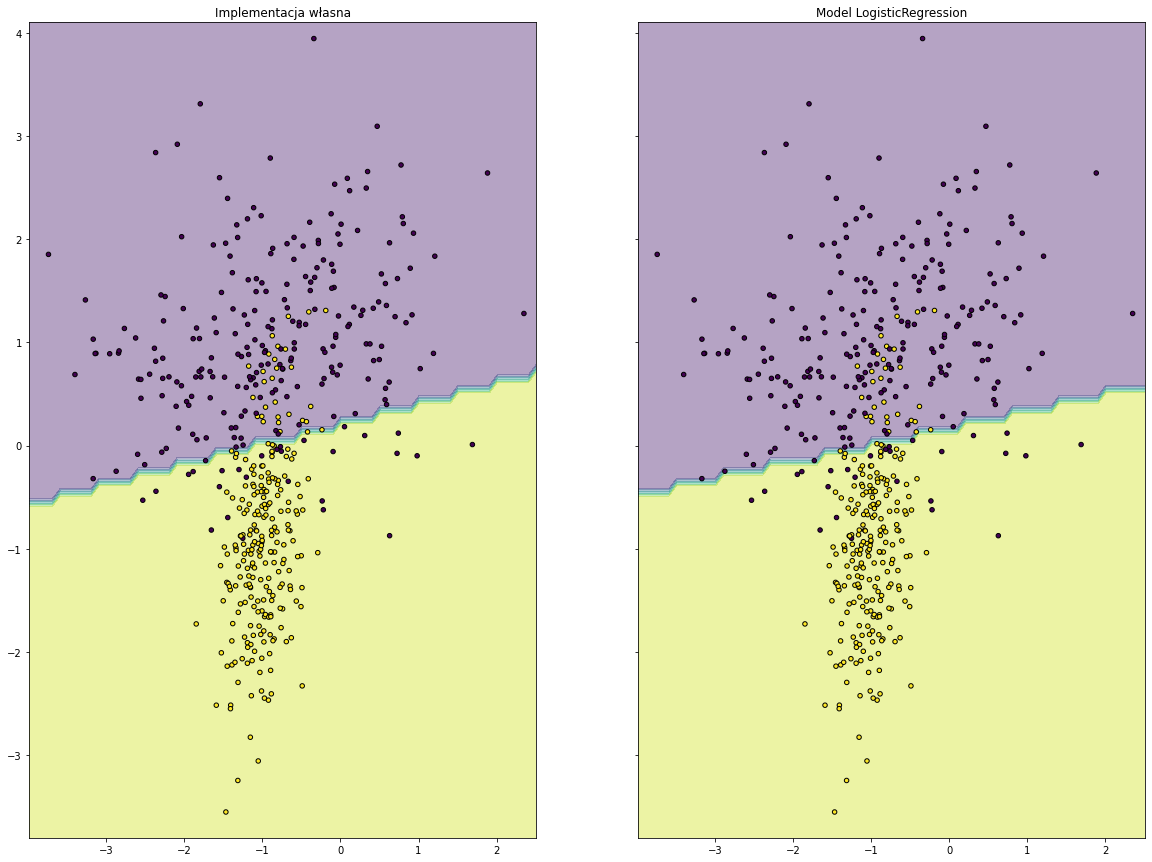

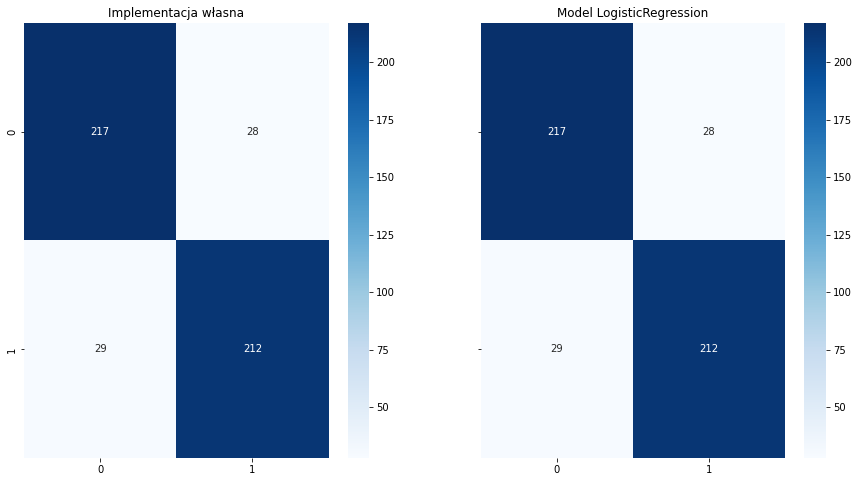

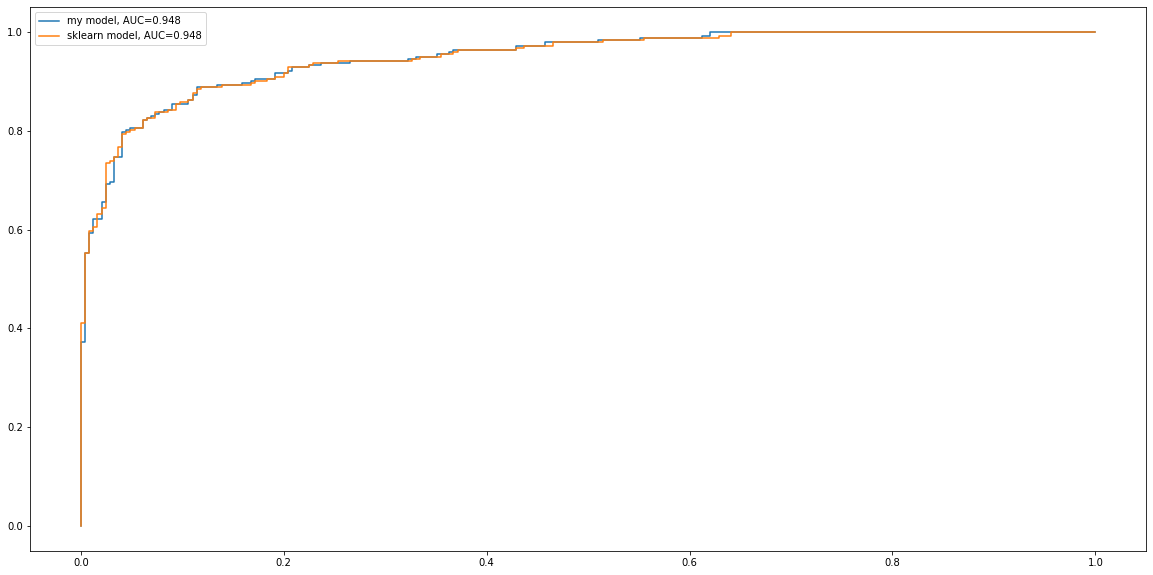

In [69]:
data_classification = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state))
my_model = MyLogisticRegression(learning_rate=0.5, max_iterations=100, min_cost_diff=1e-4)
sk_model = LogisticRegression(max_iter=100, random_state=random_state)
compare_models(my_model, sk_model, data_classification)

Implementacja wlasna uczyla sie przez 	94736100 ns
Model sklearn uczyl sie przez 			2987200 ns


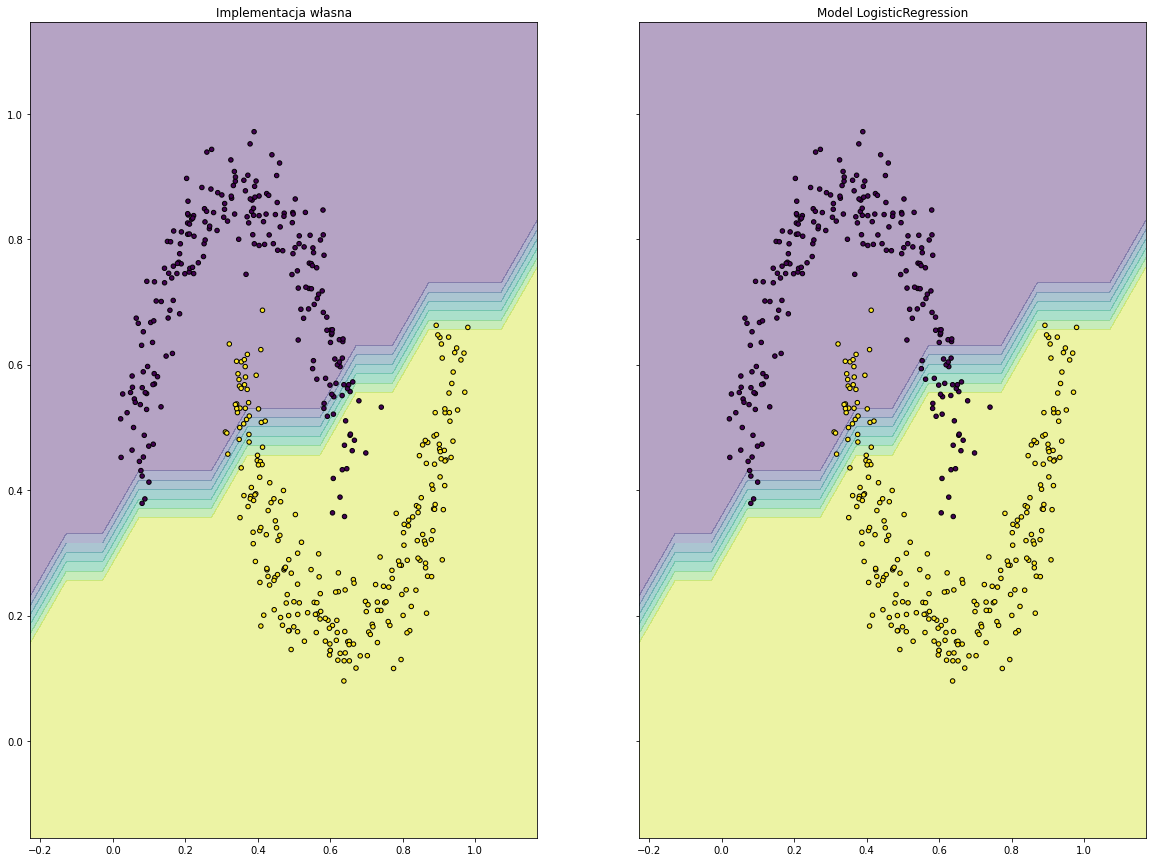

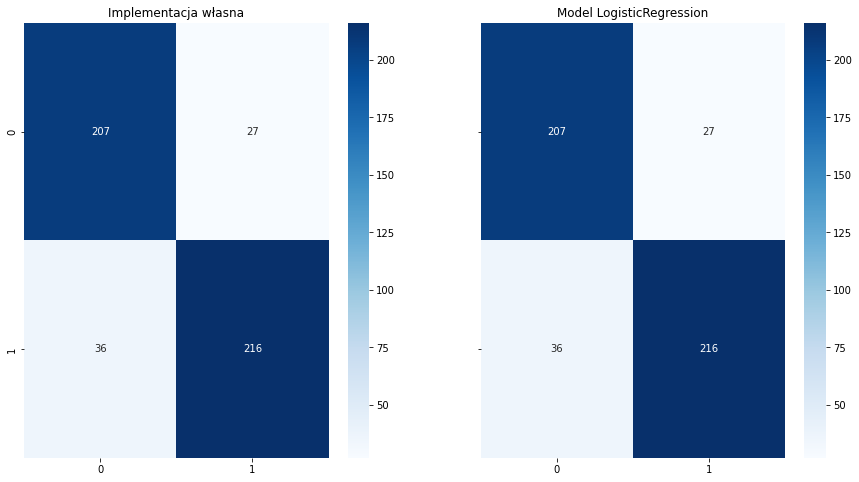

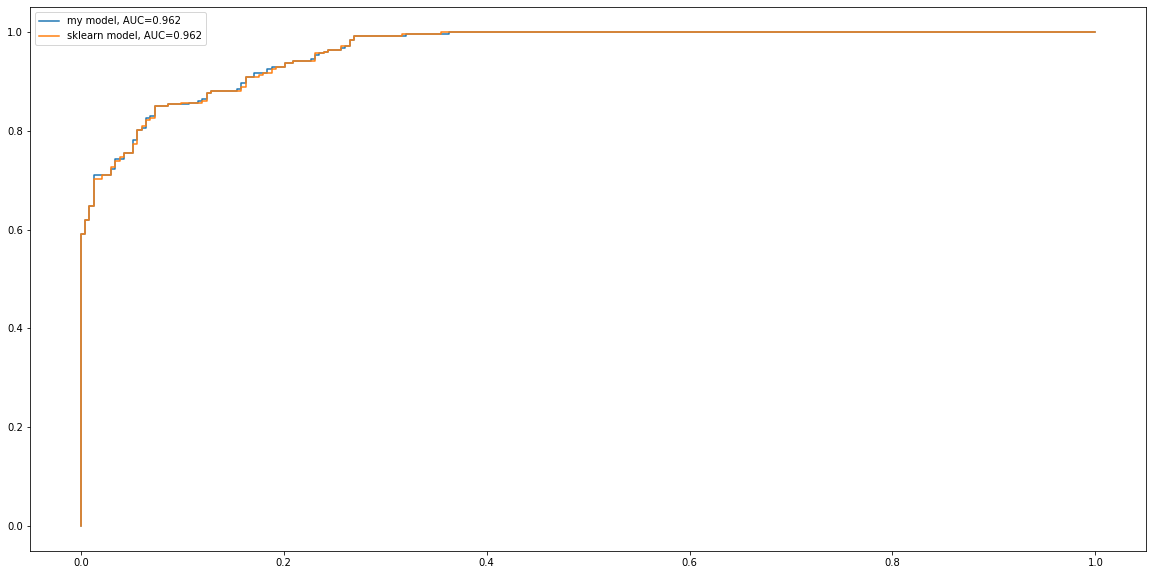

In [71]:
data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state))
data_moons.normalize()
my_model = MyLogisticRegression(learning_rate=0.75, max_iterations=10000, min_cost_diff=1e-10)
sk_model = LogisticRegression(max_iter=100, random_state=random_state)
compare_models(my_model, sk_model, data_moons)